# Time-Coverage Integrated Plots

This notebook produces **integrated Time Performance & Coverage charts** in Seaborn, as Nitin Yadav did it originally in R.

Sebastian Sardina 2023-2024 - ssardina@gmail.com

In [32]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

# sys.dont_write_bytecode = True  # prevent creation of .pyc files

STATS_CSV_FILE = os.path.join("data_stats.csv")
CSV_FOLDER = os.path.dirname(STATS_CSV_FILE)
CSV_BASENAME = os.path.basename(STATS_CSV_FILE).split(".")[0]

## 1. Load data from CSV tables & select subset

First load CSV table with stats and then project interested set into `df_sel` dataframe. Must have following columns:

- `solver`: name of the solver.
- `domain`: name of the domain.
- `cputime`: CPU time of run.

In [37]:
df = pd.read_csv(STATS_CSV_FILE)


df.sample(100)

,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
1318,earth_observation_25.yml,A1.FOND,-1,False,14400.097058,14400.747505,343.744512,14400.186602,-1,earth_observation,25,A1
2003,first-responders-ipc08_10.yml,A2.FOND,1,True,687.579678,687.625565,61.177856,687.163867,13,first-responders-ipc08,10,A2
3721,faults-ipc08_13.yml,FX,1,True,10.984226,10.986693,22.839296,10.817005,11,faults-ipc08,13,F1
2671,first-responders-ipc08_87.yml,A3.FOND,0,False,0.415827,0.437087,38.998016,-1.000000,-1,first-responders-ipc08,87,A3
2481,earth_observation_08.yml,A3.FOND,0,False,0.430548,0.455487,39.022592,-1.000000,-1,earth_observation,8,A3
...,...,...,...,...,...,...,...,...,...,...,...,...
1399,faults-ipc08_51.yml,A1.FOND,-1,False,14400.101279,14400.741793,273.113088,14400.211595,-1,faults-ipc08,51,A1
3530,zenotravel_06.yml,A4.FOND,0,False,0.451571,0.458963,39.006208,-1.000000,-1,zenotravel,6,A4
215,faults-ipc08_47.yml,S1.FOND,1,True,0.341588,0.343743,10.047488,0.060000,21,faults-ipc08,47,S1
948,islands_35.yml,S2.FOND,1,True,106.860672,106.914322,2545.455104,106.009000,7,islands,35,S2


In [38]:
SOLVERS = df["solver"].unique()
DOMAINS = df["domain"].unique()

print("Domains found:", DOMAINS)
print("Solvers found:", SOLVERS)

Domains found: ['acrobatics' 'beam-walk' 'blocksworld-ipc08' 'blocksworld-new'
 'chain-of-rooms' 'doors' 'earth_observation' 'elevators' 'faults-ipc08'
 'first-responders-ipc08' 'islands' 'miner' 'spiky-tireworld'
 'tireworld-truck' 'tireworld' 'triangle-tireworld' 'zenotravel']
Solvers found: ['S1' 'S2' 'A1' 'A2' 'A3' 'A4' 'F1' 'F2']


Project over selected domains and solvers.

In [39]:
SOLVERS_SEL = SOLVERS   # select all solvers
DOMAINS_SEL = DOMAINS   # select all domains

print("Solvers selected:", SOLVERS)
print("Domains selected:", DOMAINS)

df_sel = df.loc[(df.solver.isin(SOLVERS)) & (df.domain.isin(DOMAINS))]

df_sel = df

df_sel.head()

Solvers selected: ['S1' 'S2' 'A1' 'A2' 'A3' 'A4' 'F1' 'F2']
Domains selected: ['acrobatics' 'beam-walk' 'blocksworld-ipc08' 'blocksworld-new'
 'chain-of-rooms' 'doors' 'earth_observation' 'elevators' 'faults-ipc08'
 'first-responders-ipc08' 'islands' 'miner' 'spiky-tireworld'
 'tireworld-truck' 'tireworld' 'triangle-tireworld' 'zenotravel']


,task,run,status,solved,cputime,walltime,memory_mb,planner_time,policy_size,domain,instance,solver
0,acrobatics_01.yml,S1.FOND,1,True,0.233342,0.235622,10.080256,0.01,4,acrobatics,1,S1
1,acrobatics_02.yml,S1.FOND,1,True,10.369209,10.374620,10.199040,10.14,8,acrobatics,2,S1
2,acrobatics_03.yml,S1.FOND,1,True,11.289586,11.302472,10.235904,11.05,16,acrobatics,3,S1
3,acrobatics_04.yml,S1.FOND,1,True,12.004272,12.007289,10.444800,11.76,32,acrobatics,4,S1
4,acrobatics_05.yml,S1.FOND,1,True,17.225556,17.242667,11.210752,16.95,64,acrobatics,5,S1


## 2. Compute rich coverage table for plotting

Now we operated on the selected dataframe `df_sel`.

First, count how MANY instances per domain:

In [40]:
selection_index = ['domain']

# count the number of each run per full_domain (e.g., how many lpg runs in Barman-EIGHT50)
count_df = df_sel.groupby(by=selection_index)['solver'].value_counts()

count_df = count_df.reset_index(name="count")

# # transofm the serie into a dataframe and value becomes percent
# coverage_df = coverage_df.mul(100).round(0).rename('percent').reset_index()
# coverage_df = coverage_df.loc[coverage_df.status].reset_index(drop=True)    # keep just the TRUE status (solved!)

count_df
# count_df.query("domain == 'miner' or domain == 'tireworld'")

,domain,solver,count
0,acrobatics,A1,8
1,acrobatics,A2,8
2,acrobatics,A3,8
3,acrobatics,A4,8
4,acrobatics,F1,8
...,...,...,...
131,zenotravel,A4,15
132,zenotravel,F1,15
133,zenotravel,F2,15
134,zenotravel,S1,15


Next calculate **coverage** for each solver run in each domain:

In [41]:
def compute_coverage(df: pd.DataFrame) -> pd.DataFrame:
    # columns to group-by
    selection_index = ["solver", "domain"]

    # count normalized (0-1) the number of grade after grouping for all the other values
    coverage_df = df.groupby(by=selection_index)["solved"].value_counts(normalize=True)

    # transofm the serie into a dataframe and value becomes percent
    coverage_df = coverage_df.mul(100).rename("percent").reset_index()

    # convert the rows that have 100% unsovable (False), to 0% solvable (True)
    #   otherwise, there will be no True solvable for those cases!
    mask_unsolvable = (~coverage_df.solved) & (coverage_df.percent == 100)
    coverage_df.loc[mask_unsolvable, ["solved", "percent"]] = [True, 0]

    # return the % of solvable stats
    return coverage_df.loc[coverage_df.solved].round(
        0
    )

coverage_df = compute_coverage(df_sel)
coverage_df

# SOME FILTERS
# coverage_df.query("not solved and percent == 100")
# coverage_df.query("solved and percent == 0")

coverage_df.query("solver == 'cfondasp1-reg'")

,solver,domain,solved,percent


Compute the CPU time mean per domain/solver.

In [42]:
selection_index = ["domain", "solver"]

# mean of cputime for SOLVED instances
cputime_mean_df = df_sel.loc[df_sel.solved].groupby(by=selection_index)["cputime"].mean().round(2)

# mean of cputime for ALL instances
# cputime_mean_df = df_sel.groupby(by=selection_index)["cputime"].mean()

cputime_mean_df = cputime_mean_df.reset_index(name="cputime_mean")

cputime_mean_df

,domain,solver,cputime_mean
0,acrobatics,A1,583.66
1,acrobatics,A2,689.00
2,acrobatics,F1,7.89
3,acrobatics,F2,178.67
4,acrobatics,S1,13.01
...,...,...,...
97,zenotravel,A2,940.04
98,zenotravel,F1,406.65
99,zenotravel,F2,170.96
100,zenotravel,S1,3.75


Join coverage table with count instances and cpu mean time tables, into a single one:

In [43]:
coverage_df = coverage_df.merge(count_df)
coverage_df = coverage_df.merge(cputime_mean_df)

coverage_df

,solver,domain,solved,percent,count,cputime_mean
0,A1,acrobatics,True,50.0,8,583.66
1,A1,beam-walk,True,27.0,11,11.94
2,A1,blocksworld-ipc08,True,33.0,30,20.18
3,A1,blocksworld-new,True,18.0,40,1123.76
4,A1,chain-of-rooms,True,20.0,10,6665.21
...,...,...,...,...,...,...
97,S2,spiky-tireworld,True,91.0,11,14.90
98,S2,tireworld,True,80.0,15,0.64
99,S2,tireworld-truck,True,78.0,74,355.53
100,S2,triangle-tireworld,True,100.0,40,12.52


## 3. Build integrated time-coverage plots

Some useful links to make nice charts:

* [Changing plot style and color](https://s3.amazonaws.com/assets.datacamp.com/production/course_15192/slides/chapter4.pdf).
* [Advanced Seaborn: Demystifying the Complex Plots!](https://levelup.gitconnected.com/advanced-seaborn-demystifying-the-complex-plots-537582977c8c#5965 )

Let's first inspect/check the coverage in a random domain:

In [44]:
import random

x = random.choice(coverage_df['domain'].unique())
coverage_df.loc[coverage_df.domain == x]

,solver,domain,solved,percent,count,cputime_mean
15,A1,triangle-tireworld,True,8.0,40,416.30
32,A2,triangle-tireworld,True,8.0,40,332.14
49,F1,triangle-tireworld,True,8.0,40,1456.86
66,F2,triangle-tireworld,True,12.0,40,1407.95
83,S1,triangle-tireworld,True,100.0,40,69.54
100,S2,triangle-tireworld,True,100.0,40,12.52


Now, the the MAIN code for plotting complex combined time-coverage charts across as done with the original R's script from Nitin for ECAI'23.

The final integrated plit is built in three stages:

1. For each domain (e.g., `acrobatics`), draw a _relational scatter subplot_ showing time performance across instances per solver/run.
2. On each subplot, superimpose the cputime mean for each solver.
3. Finally, superimpose coverage bars and % for each solver.

In each subplot, the title shows the full domain with the number of instances run (e.g., `acrobatic (20)` means 20 instances run for `acrobatic` domain).


Finished building scattered plot of cputime. Next overlapping coverage bars...


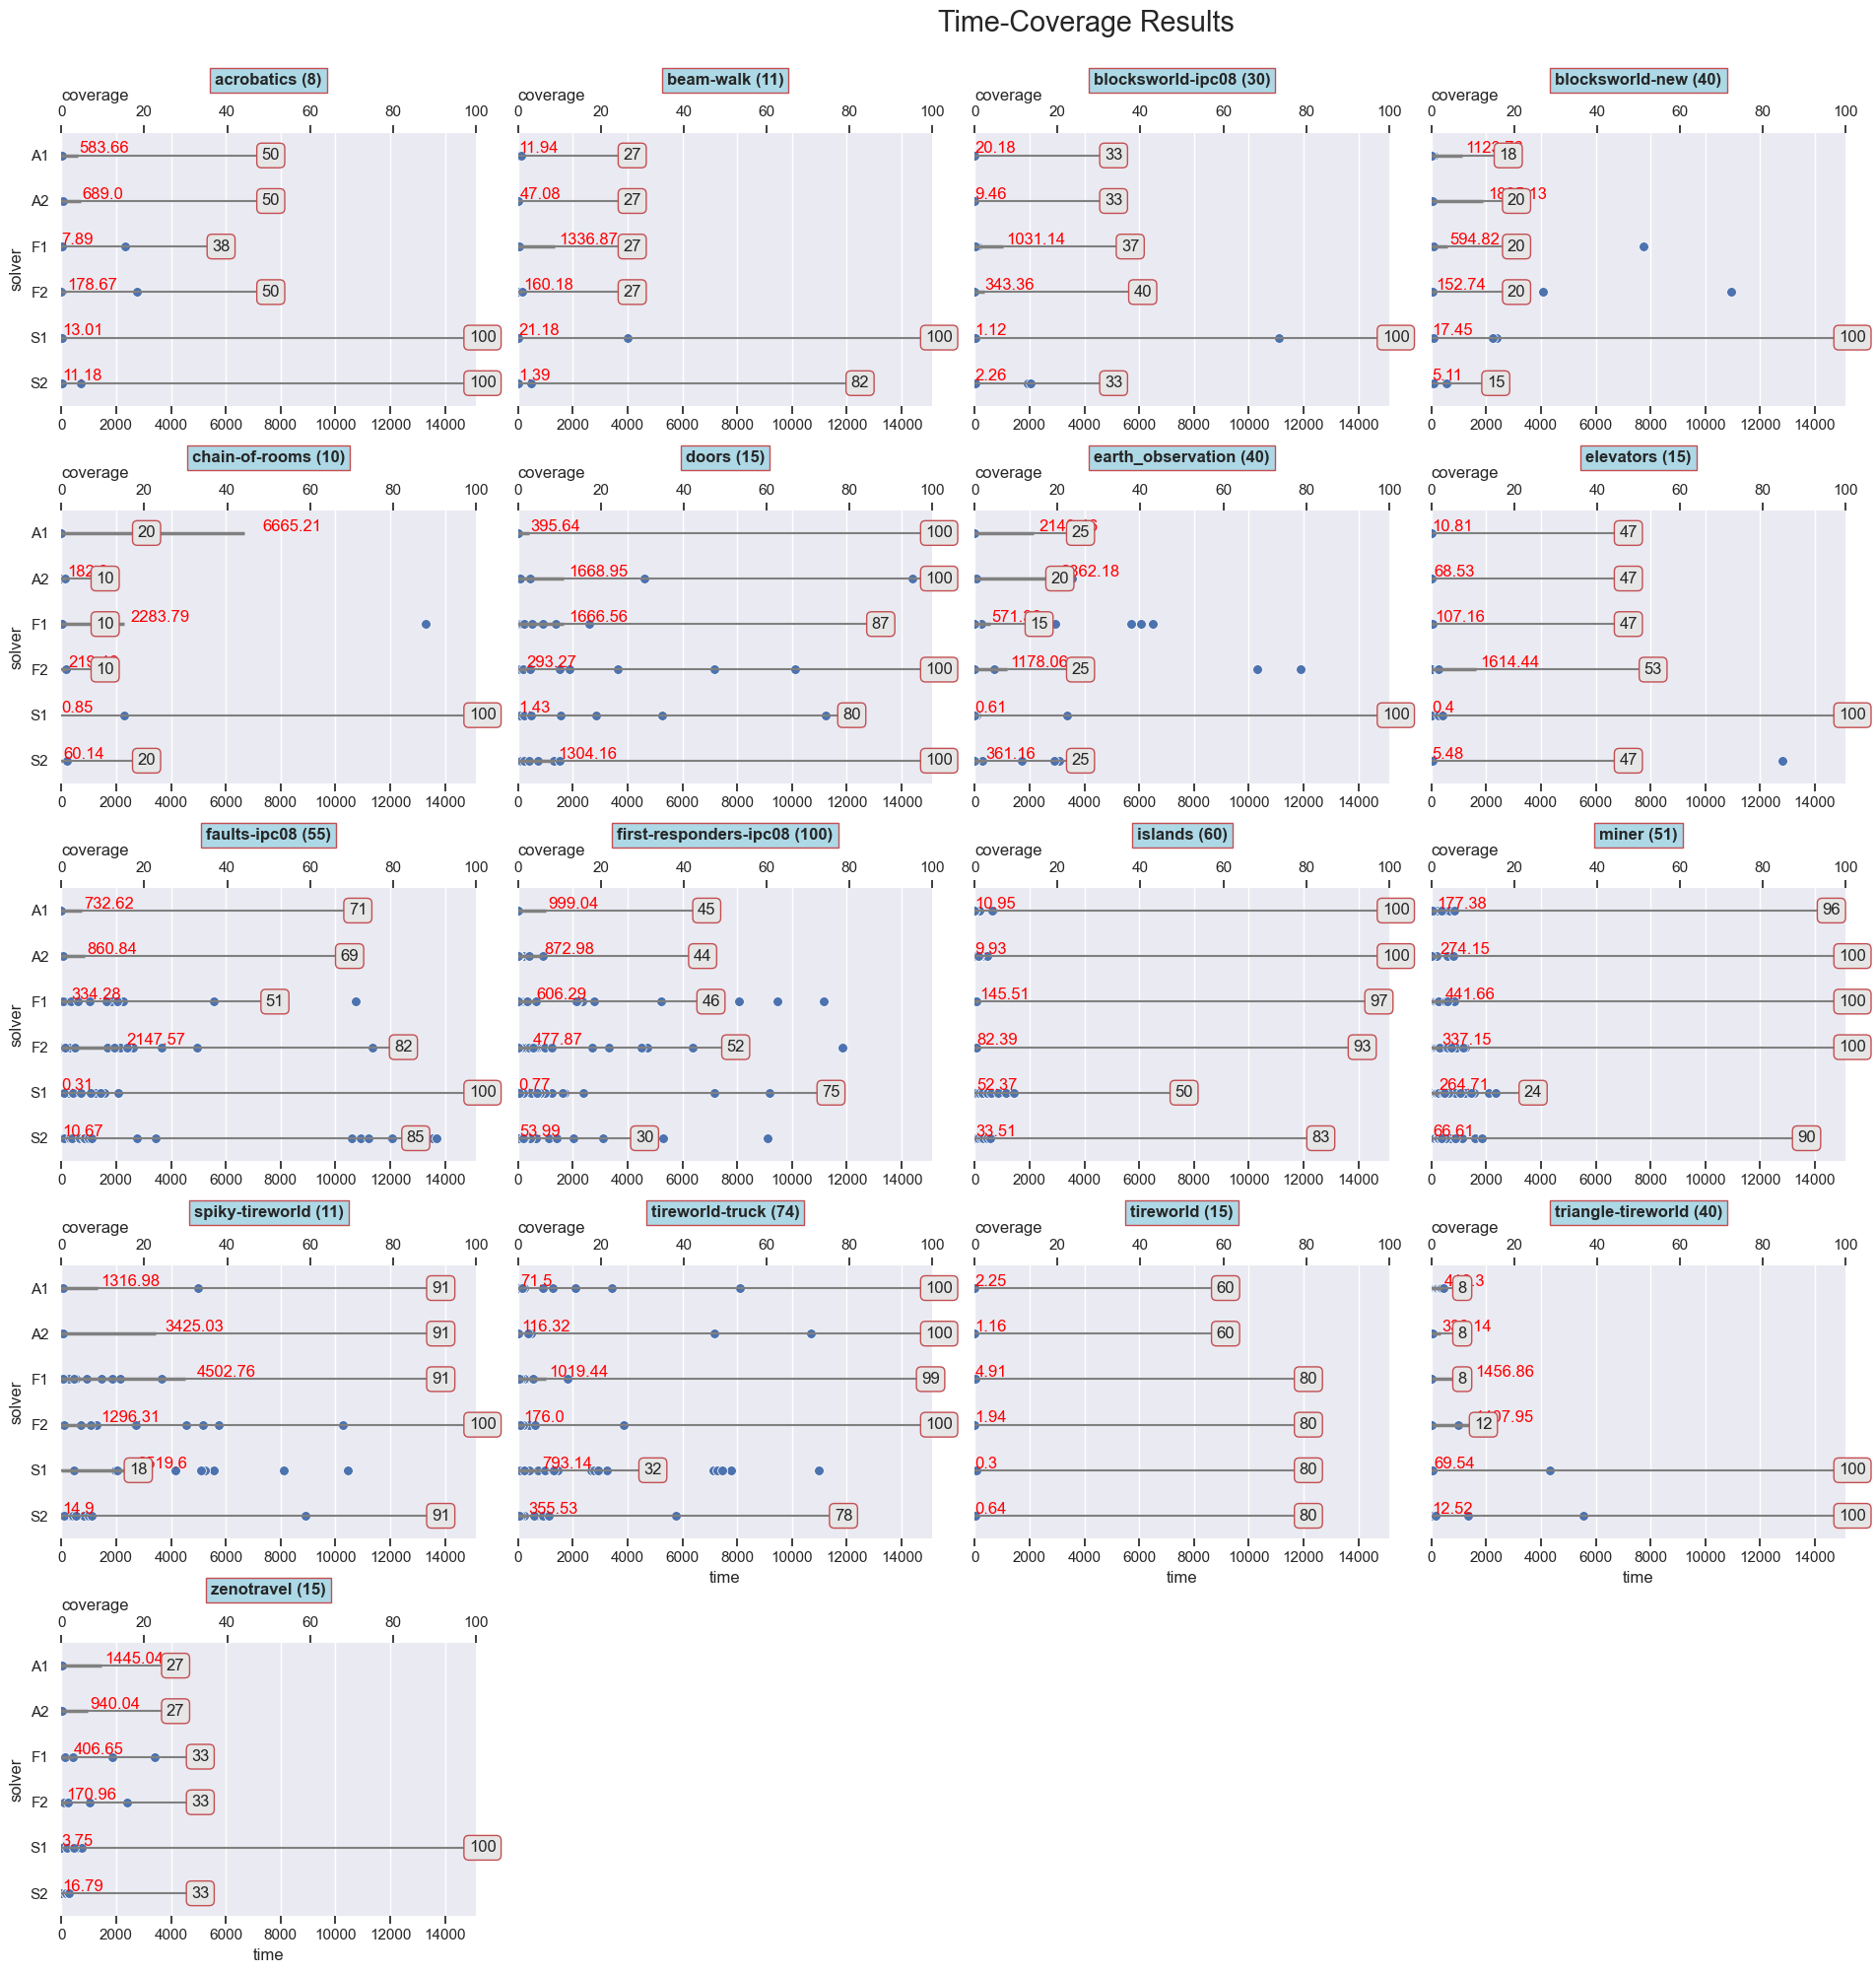

In [51]:
# set how many subplots per row
COL_WRAP = 4

# https://seaborn.pydata.org/tutorial/aesthetics.html
# https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme()
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("darkgrid")

# DEFINE BOXES USED BELOW
# box for the title of each subplot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.FancyBboxPatch.html#matplotlib.patches.FancyBboxPatch
bbox_title = dict(boxstyle="square", fc="lightblue", fill=True, color="r")
bbox_coverage = dict(boxstyle="round", fc="0.9", fill=True, color="r")
bbox_cputime = dict(boxstyle=None, fc="0.9", fill=True, color="r")

####################################################################################
## FIRST, produce one scatter subplot per domain with x=cputime and y=solver
# https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot
####################################################################################
g = sns.relplot(
    data=df_sel.query("solved"),
    kind="scatter",
    s=50,
    x="cputime",
    y="solver",
    col="domain",  # one subplot per domain
    col_wrap=COL_WRAP,
    height=4,
    aspect=1.2,
)

# Let's set titles
g.set_axis_labels("time", "solver")
g.set_titles(  #   most options are passed to text: https://matplotlib.org/stable/api/text_api.html
    col_template="{col_name}",
    fontweight="demibold",
    ha="center",
    va="center",
    bbox=bbox_title,
)
g.figure.suptitle(
    f"Time-Coverage Results", ha="left", va="top", fontsize="xx-large", y=1
)  # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html


print("Finished building scattered plot of cputime. Next overlapping coverage bars...")

# get all the axes (subplots) of the FaceGrid
axes = g.axes.flatten()
sns.set_style("ticks")  # just ticks, no grid from now on...

####################################################################################
# SECOND, super-impose cputime mean numbers per solver in each subplot in the grid
####################################################################################
for ax in axes:
    domain = ax.get_title()
    g_cpumean = sns.barplot(  # draw the bar of mean cputime per solver
        data=coverage_df[coverage_df.domain.eq(domain)],
        x="cputime_mean",
        y="solver",
        width=0.0001,
        linewidth=2.5,
        edgecolor=".5",
        facecolor=(0, 0, 0, 0),
        ax=ax,
    )
    g_cpumean.set(xlabel=None)

    # add cpu mean number per solver, but a bit up to not clash with coverage bar!
    # https://stackoverflow.com/questions/70693878/flexible-placement-of-labels-in-seaborn-barplots
    for p in ax.patches:
        perc = p.get_width()  # the label for the bar
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2

        ax.annotate(perc, (x * 1.1, y - 0.05), color="red")

    # this will add the cpu mean per solver, but will clash with the coverage bar!
    # if len(ax.containers) > 0: # may not be no number!
    #     ax.bar_label(  # set the mean number in the bar at the end (cannot shift tup!)
    #         ax.containers[0],
    #         fmt="%.2f",
    #         label_type="edge",
    #         padding=5,
    #         fontweight="normal",
    #         rotation="horizontal",
    # )


####################################################################################
## THIRD, super-impose the COVERAGE data in each subplot in the grid as done in
#   https://stackoverflow.com/a/67612124
#   we also rename the title of each subplot to include no of instances run
#   we iterate on each axis and plot a barplot and add annotations/styles to it
####################################################################################
for ax in axes:
    # redo title of subfigure to include number of instances between parenthesis, e.g., BARMAN-EIGHT50 (20)
    domain = ax.get_title()
    no_instances = coverage_df.loc[coverage_df.domain == ax.get_title()][
        "count"
    ].unique()[0]
    ax.set_title(
        f"{domain} ({no_instances})",
        fontweight="demibold",
        ha="center",
        va="center",
        bbox=bbox_title,
    )

    # add bar of coverage % for each run/solver
    ax2 = (
        ax.twiny()
    )  # get a twin y-axies https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html
    g2 = sns.barplot(
        data=coverage_df[coverage_df.domain.eq(domain)],
        x="percent",
        y="solver",
        width=0.0001,
        linewidth=1.5,
        edgecolor=".5",
        facecolor=(0, 0, 0, 0),
        ax=ax2,
    )
    g2.set_xlabel("coverage", x=0, ha="left")
    g2.set_xlim([0, 100])

    # add box with % of coverage at the end of the barline, if any!
    if len(ax2.containers) > 0:
        ax2.bar_label(
            ax2.containers[0],
            label_type="edge",
            padding=-5,
            fontweight="normal",
            rotation="horizontal",
            bbox=bbox_coverage,
        )

# set the axis labels for the whole plot
g.set_axis_labels("time", "solver")

# axes[0].legend().remove()
# g.set_axis_labels(x_var=None, y_var=None, clear_inner=True)
sns.despine(left=True, bottom=True)  # no spines at all

# Save it later, not here.
# plt.savefig(os.path.join(CSV_FOLDER, f"{SET}_plot.png"))

plt.tight_layout()  # at the end adjust so everything fits tight but well
plt.show()

Double check some of the numbers there to make sure they match!

In [52]:
df_sel.query("solver == 'A1' and domain == 'islands' and solved")['cputime'].mean()

10.947040649999998

Finally, save plot in a PNG file:

In [53]:
PLOT_FILE = os.path.splitext(STATS_CSV_FILE)[0] + "_plot.png"

g.savefig(PLOT_FILE)

print("Integrated time-coverage plot saved to", PLOT_FILE)

Integrated time-coverage plot saved to data_stats_plot.png
